In [ ]:
# Install Keras
!pip install statsmodels

In [ ]:
import tensorflow as tf
import pandas as pd
import math
import numpy
import random
import decimal
import scipy.linalg
import statsmodels.api as sm
from scipy import stats
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
from sklearn import svm
import itertools
import sklearn
from sklearn.metrics import r2_score
%matplotlib inline

In [ ]:
import keras
from keras.models import Sequential, model_from_json, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Conv2D, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Reshape

In [ ]:
class ModelParameters:
    """
    Encapsulates model parameters
    """
    
    def __init__(self,
                 all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0):
        
        # This is the amount of time to simulate for
        self.all_time = all_time
        
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        
        # This is the volatility of the stochastic processes
        # 0.001,1
        self.all_sigma = all_sigma
        
        # This is the annual drift factor for geometric brownian motion
        # -1,1
        self.gbm_mu = gbm_mu
        
        # This is the probability of a jump happening at each point in time
        #  0.0003,0.025
        self.lamda = jumps_lamda
        
        # This is the volatility of the jump size
        #   0.001, 1
        self.jumps_sigma = jumps_sigma
        
        # This is the average jump size
        # -0.1,0.1
        self.jumps_mu = jumps_mu
        

def random_model_params():
    
    return ModelParameters(
        # Fixed Parameters
        all_time=2000,
        all_delta=0.00396825396,
        
        # Random Parameters
        
        ### TODO: REDUCED SIGMA #######################
        all_sigma = nrand.uniform(0.001,0.2),
        ##############################################
        
        gbm_mu = nrand.uniform(-1,1),
        jumps_lamda=nrand.uniform(0.0001,0.025),
        jumps_sigma=nrand.uniform(0.001, 0.2),
        jumps_mu=nrand.uniform(-0.5,0.5),
    )

In [ ]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    x_axis = numpy.arange(0, len(processes[0]), 1)
    for i in range(len(processes)):
        plt.plot(x_axis, processes[i])
    plt.show()

In [ ]:
def brownian_motion_log_returns(param):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    :param param: the model parameters object
    :return: brownian motion log returns
    """
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)

def geometric_brownian_motion_log_returns(param):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    :param param: model parameters object
    :return: returns the log returns of a geometric brownian motion process
    """
    assert isinstance(param, ModelParameters)
    wiener_process = numpy.array(brownian_motion_log_returns(param))
    sigma_pow_mu_delta = (param.gbm_mu - 0.5 * math.pow(param.all_sigma, 2.0)) * param.all_delta
    return wiener_process + sigma_pow_mu_delta

def jump_diffusion_process(param):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    :param param: the model parameters object
    :return: jump sizes for each point in time (mostly zeroes if jumps are infrequent)
    """
    assert isinstance(param, ModelParameters)
    s_n = time = 0
    small_lamda = -(1.0 / param.lamda)
    jump_sizes = np.zeros(param.all_time)
    while s_n < param.all_time:
        s_n += small_lamda * math.log(random.uniform(0, 1))
        for j in range(0, param.all_time):
            if time * param.all_delta <= s_n * param.all_delta <= (j + 1) * param.all_delta:
                jump_sizes[j] += random.normalvariate(param.jumps_mu, param.jumps_sigma)
                break
        time += 1
    return jump_sizes

def geometric_brownian_motion_jump_diffusion_log_returns(param):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    :param param: model parameters object
    :return: returns a GBM process with jumps in it
    """
    assert isinstance(param, ModelParameters)
    jump_diffusion = jump_diffusion_process(param)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(param)
    return numpy.add(jump_diffusion, geometric_brownian_motion)

# Metrics

### R Squared

In [ ]:
def r2(y_true, y_pred):
    SSE = K.sum(K.square(y_true-y_pred))
    SST = K.sum(K.square(y_true-K.mean(y_true)))
    return 1-SSE/SST

### Average absolute percentage error

In [ ]:
def aape(y_true, y_pred):
    MSE = K.mean(K.abs((y_true-y_pred)/y_true))
    return 100*MSE

# Feedforward (using Moments & ACF)

In [ ]:
feedforward = Sequential()
feedforward.add(Dense(2014, input_dim = 60, activation='elu'))
feedforward.add(Dense(1024, activation='elu'))
feedforward.add(Dense(512, activation='elu'))
feedforward.add(Dense(256, activation='elu'))
feedforward.add(Dense(128, activation='elu'))
feedforward.add(Dense(64, activation='elu'))
feedforward.add(Dense(32, activation='elu'))
feedforward.add(Dense(16, activation='elu'))
feedforward.add(Dense(5))

In [ ]:
# Compile model
feedforward.compile(loss='mse', optimizer='adam', metrics=[r2])

I didn't normalise the training data. It took more than 60 epochs to train this network originally.

In [ ]:
#feedforward.save("feedforward.h5")
feedforward = load_model("feedforward_running.h5")

In [ ]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])

        yield train_statistics, train_targets

In [ ]:
train_gen = batch_generator(paramset_size=10, paths_p_paramset=1)


In [ ]:
histories = []

In [ ]:
for i in range(150):
    print(str(i%9))
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 50, epochs = 1)
    histories.append(history.history)
    feedforward.save("feedforward_running_gen.h5")

# Feedforward 2

In [ ]:
input_1 = Input(batch_shape = (None, 60))

layer1 = Dense(2048, activation='elu')(input_1)
layer2 = Dense(1024, activation='elu')(layer1)

layer3 = Dense(512, activation='elu')(layer2)
layer4 = Dense(256, activation='elu')(layer3)

layer5 = Dense(128, activation='elu')(layer4)
layer6 = Dense(64, activation='elu')(layer5)

layer7 = Dense(32, activation='elu')(layer5)
last_layer = Dense(16, activation='elu')(layer7)

output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [ ]:
feedforward = Model(input = input_1, output=[output1, output2, output3, output4, output5])

In [ ]:
# Compile model
feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

In [ ]:
feedforward_CallBack = keras.callbacks.TensorBoard(log_dir='./feedforward', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

train_gen = batch_generator(paramset_size=750, paths_p_paramset=1)

In [ ]:
feedforward.load_weights("feedforward_running_gen_2.h5")

In [ ]:
#mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda
mp = ModelParameters(
        # Fixed Parameters
        all_time=2000,
        all_delta=0.00396825396,
        
        # Random Parameters
        
        ### TODO: REDUCED SIGMA #######################
        all_sigma = 0.1,
        ##############################################
        
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02,
    )
test_set = []
for i in range(1000):
    if (i%100 == 0):
        print(i)
    test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

In [ ]:
train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]

train_statistics2 = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(test_set[i])) 
                    for i in range(len(test_set))])

In [ ]:
histories2 = np.load("feedforward_mo_histories.npy").tolist()
ff_predicts = np.load("ff_predicts.npy").tolist()
#histories2 = []
#ff_predicts = []

In [19]:
for i in range(1000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 5, epochs = 1)
    histories2.append(history.history)
    ff_predicts.append(feedforward.predict(train_statistics2))
    feedforward.save_weights("feedforward_running_gen_2.h5")
    
    np.save("feedforward_mo_histories.npy", histories2)
    np.save("ff_predicts.npy", ff_predicts)
    
    !git add --all
    !git commit -am "updated history, predictions and model"
    !git push -u origin master --quiet

5/5 [==============================] - 44s - loss: 0.0390 - sigma_loss: 0.0032 - mu_loss: 0.0227 - jump_sigma_loss: 0.0030 - jump_mu_loss: 0.0099 - lambda_loss: 2.2362e-04 - sigma_r2: 0.0195 - sigma_mean_absolute_percentage_error: 210.4665 - mu_r2: 0.9320 - mu_mean_absolute_percentage_error: 94.3029 - jump_sigma_r2: 0.0923 - jump_sigma_mean_absolute_percentage_error: 175.2305 - jump_mu_r2: 0.8792 - jump_mu_mean_absolute_percentage_error: 176.2513 - lambda_r2: -3.2894 - lambda_mean_absolute_percentage_error: 242.8221     
[master 3c330e7] updated history, predictions and model
 5 files changed, 5814 insertions(+), 11278 deletions(-)
 rewrite .ipynb_checkpoints/MertonJumpDiffusion-Convolution2-checkpoint.ipynb (89%)
 rewrite MertonJumpDiffusion-Convolution2.ipynb (89%)
Branch master set up to track remote branch master from origin.
Epoch 1/1
5/5 [==============================] - 45s - loss: 0.0396 - sigma_loss: 0.0033 - mu_loss: 0.0239 - jump_sigma_loss: 0.0029 - jump_mu_loss: 0.0092 - 

KeyboardInterrupt: 

In [ ]:
np.save("feedforward_mo_histories.npy", histories2)

In [20]:
sigma_mean_absolute_percentage_error = []
lambda_mean_absolute_percentage_error = []
jump_sigma_mean_absolute_percentage_error = []
jump_mu_mean_absolute_percentage_error = []
mu_mean_absolute_percentage_error = []

sigma_r2 = []
lambda_r2 = []
jump_sigma_r2 = []
mu_r2 = []
jump_mu_r2 = []

jump_mu_loss = []
lambda_loss = []
sigma_loss = []
mu_loss = []
jump_sigma_loss = []

loss = []

for history in histories2:
    sigma_mean_absolute_percentage_error.append(history['sigma_mean_absolute_percentage_error'])
    lambda_mean_absolute_percentage_error.append(history['lambda_mean_absolute_percentage_error'])
    jump_sigma_mean_absolute_percentage_error.append(history['jump_sigma_mean_absolute_percentage_error'])
    jump_mu_mean_absolute_percentage_error.append(history['jump_mu_mean_absolute_percentage_error'])
    mu_mean_absolute_percentage_error.append(history['mu_mean_absolute_percentage_error'])
    
    sigma_r2.append(history['sigma_r2'])
    lambda_r2.append(history['lambda_r2'])
    jump_sigma_r2.append(history['jump_sigma_r2'])
    mu_r2.append(history['mu_r2'])
    jump_mu_r2.append(history['jump_mu_r2'])
    
    jump_mu_loss.append(history['jump_mu_loss'])
    lambda_loss.append(history['lambda_loss'])
    sigma_loss.append(history['sigma_loss'])
    mu_loss.append(history['mu_loss'])
    jump_sigma_loss.append(history['jump_sigma_loss'])
    
    loss.append(history['loss'])

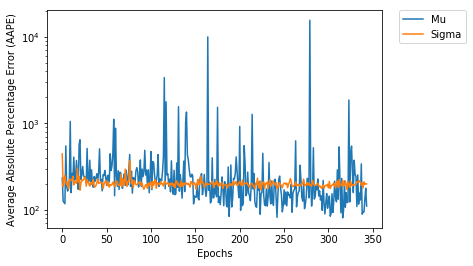

In [21]:
plt.plot(mu_mean_absolute_percentage_error, label="Mu")
plt.plot(sigma_mean_absolute_percentage_error, label="Sigma")
plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

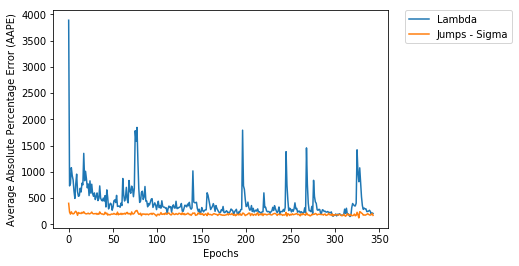

In [22]:
plt.plot(lambda_mean_absolute_percentage_error, label="Lambda")
plt.plot(jump_sigma_mean_absolute_percentage_error, label="Jumps - Sigma")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

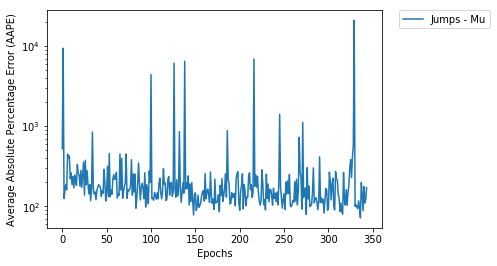

In [23]:
plt.plot(jump_mu_mean_absolute_percentage_error, label="Jumps - Mu")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

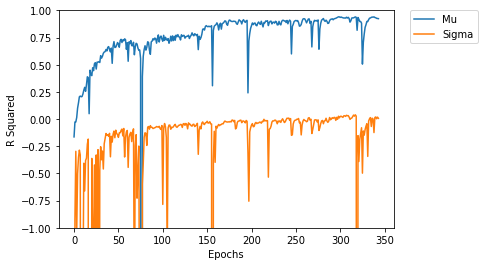

In [24]:
plt.figure()
plt.plot(mu_r2, label="Mu")
plt.plot(sigma_r2, label="Sigma")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-1, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

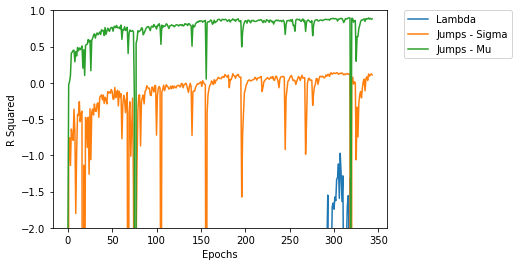

In [25]:
plt.figure()
plt.plot(lambda_r2, label="Lambda")
plt.plot(jump_sigma_r2, label="Jumps - Sigma")
plt.plot(jump_mu_r2, label="Jumps - Mu")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-2, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

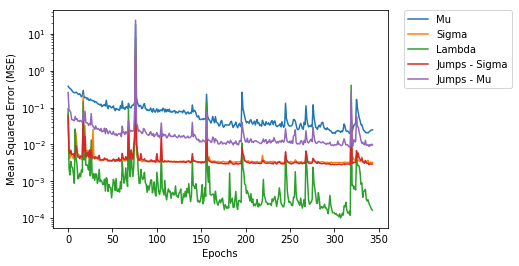

In [26]:
plt.plot(mu_loss, label="Mu")
plt.plot(sigma_loss, label="Sigma")
plt.plot(lambda_loss, label="Lambda")
plt.plot(jump_sigma_loss, label="Jumps - Sigma")
plt.plot(jump_mu_loss, label="Jumps - Mu")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
plt.show()

# Feedforward  RELU

In [27]:
input_1 = Input(batch_shape = (None, 60))

layer1 = Dense(2048, activation='relu')(input_1)
layer2 = Dense(1024, activation='relu')(layer1)

layer3 = Dense(512, activation='relu')(layer2)
layer4 = Dense(256, activation='relu')(layer3)

layer5 = Dense(128, activation='relu')(layer4)
layer6 = Dense(64, activation='relu')(layer5)

layer7 = Dense(32, activation='relu')(layer5)
last_layer = Dense(16, activation='relu')(layer7)

output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [28]:
feedforward = Model(input = input_1, output=[output1, output2, output3, output4, output5])

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [29]:
# Compile model
feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

In [30]:
feedforward_CallBack = keras.callbacks.TensorBoard(log_dir='./feedforward', histogram_freq=0, write_graph=True, write_images=True)

In [31]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

train_gen = batch_generator(paramset_size=250, paths_p_paramset=1)

In [32]:
feedforward.load_weights("feedforward_running_gen_2_relu.h5")

In [33]:
#mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda
mp = ModelParameters(
        # Fixed Parameters
        all_time=2000,
        all_delta=0.00396825396,
        
        # Random Parameters
        
        ### TODO: REDUCED SIGMA #######################
        all_sigma = 0.1,
        ##############################################
        
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02,
    )
test_set = []
for i in range(1000):
    if (i%100 == 0):
        print(i)
    test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

0
100
200
300
400
500
600
700
800
900


In [34]:
train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]

train_statistics2 = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(test_set[i])) 
                    for i in range(len(test_set))])

In [ ]:
histories2_relu = np.load("feedforward_mo_histories_relu.npy").tolist()
ff_predicts_relu = np.load("ff_predicts_relu.npy").tolist()
#histories2_relu = []
#ff_predicts_relu = []

In [ ]:
for i in range(1000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 50, epochs = 1)
    histories2_relu.append(history.history)
    ff_predicts_relu.append(feedforward.predict(train_statistics2))
    feedforward.save_weights("feedforward_running_gen_2_relu.h5")
    
    np.save("feedforward_mo_histories_relu.npy", histories2_relu)
    np.save("ff_predicts_relu.npy", ff_predicts_relu)
    
    !git add --all
    !git commit -am "updated history, predictions and model"
    #!git remote add origin https://RWMostert:N0ne\ of\ that.@github.com/RWMostert/Merton-Jump-Diffusion-Calibration-Tests.git
    !git push -u origin master --quiet

Epoch 1/1
50/50 [==============================] - 150s - loss: 0.0728 - sigma_loss: 0.0033 - mu_loss: 0.0545 - jump_sigma_loss: 0.0029 - jump_mu_loss: 0.0120 - lambda_loss: 6.6288e-05 - sigma_r2: 0.0049 - sigma_mean_absolute_percentage_error: 191.7328 - mu_r2: 0.8355 - mu_mean_absolute_percentage_error: 248.7087 - jump_sigma_r2: 0.1064 - jump_sigma_mean_absolute_percentage_error: 176.9909 - jump_mu_r2: 0.8557 - jump_mu_mean_absolute_percentage_error: 167.0197 - lambda_r2: -0.3015 - lambda_mean_absolute_percentage_error: 127.7429   
[master 00903e9] updated history, predictions and model
 4 files changed, 164 insertions(+), 26 deletions(-)
 rewrite feedforward_mo_histories_relu.npy (95%)
To https://RWMostert:N0ne of that.@github.com/RWMostert/Merton-Jump-Diffusion-Calibration-Tests.git
 ! [rejected]        master -> master (fetch first)
error: failed to push some refs to 'https://RWMostert:N0ne of that.@github.com/RWMostert/Merton-Jump-Diffusion-Calibration-Tests.git'
hint: Updates wer

In [ ]:
np.save("feedforward_mo_histories.npy", histories2)

In [ ]:
sigma_mean_absolute_percentage_error = []
lambda_mean_absolute_percentage_error = []
jump_sigma_mean_absolute_percentage_error = []
jump_mu_mean_absolute_percentage_error = []
mu_mean_absolute_percentage_error = []

sigma_r2 = []
lambda_r2 = []
jump_sigma_r2 = []
mu_r2 = []
jump_mu_r2 = []

jump_mu_loss = []
lambda_loss = []
sigma_loss = []
mu_loss = []
jump_sigma_loss = []

loss = []

for history in histories2:
    sigma_mean_absolute_percentage_error.append(history['sigma_mean_absolute_percentage_error'])
    lambda_mean_absolute_percentage_error.append(history['lambda_mean_absolute_percentage_error'])
    jump_sigma_mean_absolute_percentage_error.append(history['jump_sigma_mean_absolute_percentage_error'])
    jump_mu_mean_absolute_percentage_error.append(history['jump_mu_mean_absolute_percentage_error'])
    mu_mean_absolute_percentage_error.append(history['mu_mean_absolute_percentage_error'])
    
    sigma_r2.append(history['sigma_r2'])
    lambda_r2.append(history['lambda_r2'])
    jump_sigma_r2.append(history['jump_sigma_r2'])
    mu_r2.append(history['mu_r2'])
    jump_mu_r2.append(history['jump_mu_r2'])
    
    jump_mu_loss.append(history['jump_mu_loss'])
    lambda_loss.append(history['lambda_loss'])
    sigma_loss.append(history['sigma_loss'])
    mu_loss.append(history['mu_loss'])
    jump_sigma_loss.append(history['jump_sigma_loss'])
    
    loss.append(history['loss'])

In [ ]:
plt.plot(mu_mean_absolute_percentage_error, label="Mu")
plt.plot(sigma_mean_absolute_percentage_error, label="Sigma")
plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.plot(lambda_mean_absolute_percentage_error, label="Lambda")
plt.plot(jump_sigma_mean_absolute_percentage_error, label="Jumps - Sigma")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.plot(jump_mu_mean_absolute_percentage_error, label="Jumps - Mu")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.figure()
plt.plot(mu_r2, label="Mu")
plt.plot(sigma_r2, label="Sigma")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-1, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.figure()
plt.plot(lambda_r2, label="Lambda")
plt.plot(jump_sigma_r2, label="Jumps - Sigma")
plt.plot(jump_mu_r2, label="Jumps - Mu")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-2, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.plot(mu_loss, label="Mu")
plt.plot(sigma_loss, label="Sigma")
plt.plot(lambda_loss, label="Lambda")
plt.plot(jump_sigma_loss, label="Jumps - Sigma")
plt.plot(jump_mu_loss, label="Jumps - Mu")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
plt.show()

# Feedforward Single Paramter - MU

In [ ]:
input_1 = Input(batch_shape = (None, 60))

layer1 = Dense(2048, activation='relu')(input_1)
layer2 = Dense(1024, activation='relu')(layer1)

dropout1 = Dropout(0.2)(layer2)

layer3 = Dense(512, activation='relu')(dropout1)
layer4 = Dense(256, activation='relu')(layer3)

dropout2 = Dropout(0.2)(layer4)

layer5 = Dense(128, activation='relu')(dropout2)
layer6 = Dense(64, activation='relu')(layer5)

dropout3 = Dropout(0.2)(layer6)

layer7 = Dense(32, activation='relu')(dropout3)
last_layer = Dense(16, activation='relu')(layer7)

output2 = Dense(1, name="mu")(last_layer)

feedforward_mu = Model(input = input_1, output=[output2])
# Compile model
feedforward_mu.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

feedforward_mu_CallBack = keras.callbacks.TensorBoard(log_dir='./feedforward_mu', histogram_freq=0, write_graph=True, write_images=True)


In [ ]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        
        yield train_statistics, [mus]

train_gen = batch_generator(paramset_size=10, paths_p_paramset=1)

In [ ]:
histories_mu = []

In [ ]:
for i in range(1000):
    history = feedforward_mu.fit_generator(train_gen, steps_per_epoch = 250, epochs = 1)
    histories_mu.append(history.history)
    feedforward_mu.save_weights("feedforward_mu.h5")

# Feedforward with ReLu's

In [ ]:
feedforward = Sequential()
feedforward.add(Dense(4096, input_dim = 60, activation='relu'))
feedforward.add(Dense(1024, activation='relu'))
feedforward.add(Dense(256, activation='relu'))
feedforward.add(Dense(5))

In [ ]:
# Compile model
feedforward.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=[r2])

In [ ]:
for i in range(150):
    print(str(i%9))
    train_statistics = np.load("FF_Statistics_"+str(i%9)+".npy")
    train_targets = np.load("FF_Targets_"+str(i%9)+".npy")
    
    feedforward.fit(np.array(train_statistics[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_statistics[80000:], train_targets[80000:]))
    feedforward.save_weights("feedforward_running_weights.h5")

# Feedforward with eLu's

In [ ]:
feedforward = Sequential()
feedforward.add(Dense(2014, input_dim = 60, activation='tanh'))
feedforward.add(Dense(1024, activation='tanh'))
feedforward.add(Dense(512, activation='tanh'))
feedforward.add(Dense(256, activation='tanh'))
feedforward.add(Dense(128, activation='tanh'))
feedforward.add(Dense(64, activation='tanh'))
feedforward.add(Dense(32, activation='tanh'))
feedforward.add(Dense(16, activation='tanh'))
feedforward.add(Dense(5))

In [ ]:
# Compile model
feedforward.compile(loss="mean_squared_error", optimizer='adam', metrics=[r2])

In [ ]:
for i in range(150):
    print(str(i%8))
    train_statistics = np.load("FF_Statistics_"+str(i%8)+".npy")
    train_targets = np.load("FF_Targets_"+str(i%8)+".npy")
    
    feedforward.fit(np.array(train_statistics[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_statistics[80000:], train_targets[80000:]))
    feedforward.save_weights("feedforward_running_weights_elu_mape.h5")

# 2D Convolutional Neural Network

In [ ]:
covnet = Sequential()
covnet.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='tanh'))
covnet.add(Convolution2D(40, 3, 3, activation='tanh', border_mode='same'))
covnet.add(MaxPooling2D(pool_size=(2,2)))

covnet.add(Convolution2D(64, 3, 3, border_mode='same', activation='tanh'))
covnet.add(Convolution2D(64, 3, 3, activation='tanh', border_mode='same'))
covnet.add(MaxPooling2D(pool_size=(2,2)))

covnet.add(Convolution2D(128, 3, 3, border_mode='same', activation='tanh'))
covnet.add(Convolution2D(128, 3, 3, activation='tanh', border_mode='same'))
covnet.add(MaxPooling2D(pool_size=(2,2)))

covnet.add(Flatten())
covnet.add(Dense(1024, activation='tanh'))
covnet.add(Dense(512, activation='tanh'))
covnet.add(Dense(5))

In [ ]:
covnet.compile('adam', 'mean_squared_error', metrics=[r2, "mean_absolute_percentage_error"])
#covnet.load_weights("covnet_mape_running.h5")
covnet.summary()

In [ ]:
covnet.load_weights("covnet_mse_tanh_running.h5")

In [ ]:
covnet.save("covnet_y.h5")

In [ ]:
#RETURNS_, PARAMS_ = get_returns(2000)
RETURNS_ = np.load("MertonReturns_2000_0.npy")
PARAMS_ = np.load("ModelParameters_2000_0.npy")
train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

In [ ]:
random_permute = np.random.permutation(len(train_data))
train_data = train_data[random_permute]
train_targets = train_targets[random_permute]

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = covnet.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet.save_weights("covnet_mse_tanh.h5")

In [ ]:
mp = random_model_params()
mp.all_time = 2000

mp.all_sigma = 0.1
mp.gbm_mu = 0.05
mp.jumps_sigma = 0.07
mp.jumps_mu = 0.05
mp.jumps_lamda = 0.02
RETURNS_ = [geometric_brownian_motion_jump_diffusion_log_returns(mp) for i in range(1000)]

In [ ]:
dataset = np.reshape(np.array(RETURNS_), (1000, 40, 50, 1))

In [ ]:
predictions = covnet.predict(dataset)

In [ ]:
np.mean(predictions, axis = 0)

In [ ]:
np.mean(predictions, axis = 0)-1.96*np.std(predictions, axis=0)

In [ ]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

        yield train_data, train_targets

In [ ]:
train_gen = batch_generator(paramset_size=1, paths_p_paramset=10)
valid_gen = batch_generator(paramset_size=1, paths_p_paramset=1)

In [ ]:
for i in range(150):
    #history = covnet.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), batch_size=100, nb_epoch=1, validation_data=(train_data[80000:], train_targets[80000:]))
    history = covnet.fit_generator(train_gen, samples_per_epoch = 1000, nb_epoch = 30)
    covnet.save("2dCovnet_.h5")

In [ ]:
covnet.save("covnet.h5")

In [ ]:
predictions = covnet_mo.predict(train_data[80000:])

In [ ]:
parameter_MSEs = []
for p in range(train_targets.shape[1]):
    prediction_set = predictions[:,p]
    actual_values = np.array(train_targets)[80000:,p]
    error = prediction_set - actual_values
    squared_error = np.square(error)
    parameter_MSEs.append(np.average(squared_error))

In [ ]:
 mp = ModelParameters(
        all_time=2000,
        all_delta=0.00396825396,                   
        all_sigma = 0.2,
        gbm_mu = 0.05,
        jumps_lamda=0.07,
        jumps_sigma=0.03,
        jumps_mu=0.005,
    )
#mp = random_model_params()

target = np.array([mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda])

returns_0 = geometric_brownian_motion_jump_diffusion_log_returns(mp)
ret = np.reshape(np.array(returns_0), (40, 50, 1))

prediction_0 = covnet.predict(np.array([ret]))
print("Parameters:        sigma,    mu,  sigma_j, mu_j, lambda_j")
print("True Value:       ", np.round(target, decimals=4))
print("-----------")
print("Predicted:        ", np.round(prediction_0[0], decimals=4))
print("Upper confidence: ", np.round(target+1.96*np.sqrt(parameter_MSEs), decimals=4))
print("Lower confidence: ", np.round(target-1.96*np.sqrt(parameter_MSEs), decimals=4))
print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::\n")

In [ ]:
import pandas as pd
d = {'True Values:' : target,
     'Predicted:' : prediction_0[0],
    'Upper 95% Confidence:' : target+1.96*np.sqrt(parameter_MSEs),
    'Lower 95% Confidence:' : target-1.96*np.sqrt(parameter_MSEs)}

df = pd.DataFrame(d, index=['sigma', 'mu', 'jumps_sigma', 'jumps_mu', 'jumps_lambda'])
df

# JUAN SE CONVNET

In [ ]:
juan_covnet = load_model("convnet_2D.h5")


In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 50, 40, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = covnet.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet.save_weights("convnet_2D.h5")

In [ ]:
#mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda

mp = random_model_params()
mp.all_time = 2000

mp.all_sigma = 0.1
mp.gbm_mu = 0.05
mp.jumps_sigma = 0.07
mp.jumps_mu = 0.05
mp.lamda = 0.025

RETURNS_ = []
for i in range(1000):
    if i%100 == 0: 
        print(i)
    RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

In [ ]:
from scipy.stats import mode

In [ ]:
dataset = np.reshape(np.array(RETURNS_), (1000, 40, 50, 1))
predictions = covnet_mo.predict(dataset)
np.median(predictions, axis = 1)

In [ ]:
np.mean(predictions, axis = 1) + 1.96*np.std(predictions, axis = 1)

In [ ]:
covnet.summary()

# Covnet 2

In [ ]:
cov2 = Sequential()
cov2.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov2.add(Convolution2D(40, 3, 3, activation='relu', border_mode='same'))
cov2.add(MaxPooling2D(pool_size=(2,2)))

cov2.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov2.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
cov2.add(MaxPooling2D(pool_size=(2,2)))

cov2.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
cov2.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov2.add(MaxPooling2D(pool_size=(2,2)))

cov2.add(Flatten())
cov2.add(Dense(5))

In [ ]:
cov2.compile('adam', 'mse', metrics=[r2])
cov2.summary()

In [ ]:
cov2 = load_model("cov2_y_running.h5")

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = cov2.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    cov2.save("cov2_y_running.h5")

# Covnet 3

In [ ]:
cov3 = Sequential()
cov3.add(Convolution2D(128, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov3.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov3.add(MaxPooling2D(pool_size=(2,2)))

cov3.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov3.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
cov3.add(MaxPooling2D(pool_size=(2,2)))

cov3.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
cov3.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
cov3.add(MaxPooling2D(pool_size=(2,2)))

cov3.add(Flatten())
cov3.add(Dense(5))

In [ ]:
cov3.compile('adam', 'mse', metrics=[r2])
cov3.summary()

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = cov3.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    cov3.save("cov3_y_running.h5")

# Covnet 4

In [ ]:
cov4 = Sequential()
cov4.add(Convolution2D(128, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='elu'))
cov4.add(Convolution2D(128, 3, 3, activation='elu', border_mode='same'))
cov4.add(MaxPooling2D(pool_size=(2,2)))

cov4.add(Convolution2D(64, 3, 3, border_mode='same', activation='elu'))
cov4.add(Convolution2D(64, 3, 3, activation='elu', border_mode='same'))
cov4.add(MaxPooling2D(pool_size=(2,2)))

cov4.add(Convolution2D(32, 3, 3, border_mode='same', activation='elu'))
cov4.add(Convolution2D(32, 3, 3, activation='elu', border_mode='same'))
cov4.add(MaxPooling2D(pool_size=(2,2)))

cov4.add(Flatten())
cov4.add(Dense(5))

In [ ]:
cov4.compile('adam', 'mse', metrics=[r2])
cov4.summary()

In [ ]:
cov4 = load_model("cov4_y_running.h5")
cov4CallBack = keras.callbacks.TensorBoard(log_dir='./Cov4', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    
    history = cov4.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]), callbacks=[cov4CallBack])
    cov4.save("cov4_y_running.h5")

# Covnet 5 

In [ ]:
cov5 = Sequential()
cov5.add(Convolution2D(16, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov5.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
cov5.add(MaxPooling2D(pool_size=(2,2)))

cov5.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov5.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov5.add(MaxPooling2D(pool_size=(2,2)))

cov5.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
cov5.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same'))
cov5.add(MaxPooling2D(pool_size=(2,2)))

cov5.add(Flatten())
cov5.add(Dense(512))
cov5.add(Dense(5))

In [ ]:
cov5.compile('adam', 'mse', metrics=[r2])
cov5.summary()

In [ ]:
cov5 = load_model("cov5_y_running.h5")
cov5.summary()
cov5CallBack = keras.callbacks.TensorBoard(log_dir='./Cov5', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    
    history = cov5.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]), callbacks=[cov5CallBack])
    cov5.save("cov5_y_running.h5")

# Covnet 6 - Add Dropout

In [ ]:
cov6 = Sequential()
cov6.add(Convolution2D(16, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov6.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
cov6.add(Dropout(0.2))
cov6.add(MaxPooling2D(pool_size=(2,2)))

cov6.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov6.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov6.add(Dropout(0.2))
cov6.add(MaxPooling2D(pool_size=(2,2)))

cov6.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
cov6.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same'))
cov6.add(Dropout(0.2))
cov6.add(MaxPooling2D(pool_size=(2,2)))

cov6.add(Flatten())
cov6.add(Dense(512))
cov6.add(Dense(5))

In [ ]:
cov6.compile('adam', 'mse', metrics=['accuracy'])
cov6.summary()
cov6CallBack = keras.callbacks.TensorBoard(log_dir='./Cov6', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    
    history = cov6.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]), callbacks=[cov6CallBack])
    #history = cov6.fit(np.array(train_data[:80]), np.array(train_targets[:80]), nb_epoch=150, batch_size=80)
    cov6.save("cov6_y_running.h5")

# Single Parameter Prediction Network

In [ ]:
covnet_sp = Sequential()
covnet_sp.add(Convolution2D(32, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
covnet_sp.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
covnet_sp.add(MaxPooling2D(pool_size=(4,4)))

covnet_sp.add(Flatten())
covnet_sp.add(Reshape(target_shape = (7680, 1)))
covnet_sp.add(Dense(32, activation='relu'))
covnet_sp.add(LSTM(16, name="LSTM_10"))
covnet_sp.add(Dense(1))

In [ ]:
covnet_sp.compile('adam', 'mse', metrics=[aape, r2])
covnet_sp.summary()

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.jumps_mu] for mp in PARAMS_])

    history = covnet_sp.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=10, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet_sp.save_weights("covnet_sp_running.h5")

# Covnet Lambda

In [ ]:
covnet_lambda = Sequential()
covnet_lambda.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
covnet_lambda.add(Convolution2D(40, 3, 3, activation='relu', border_mode='same'))
covnet_lambda.add(MaxPooling2D(pool_size=(2,2)))

covnet_lambda.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
covnet_lambda.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
covnet_lambda.add(MaxPooling2D(pool_size=(2,2)))

covnet_lambda.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
covnet_lambda.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
covnet_lambda.add(MaxPooling2D(pool_size=(2,2)))

covnet_lambda.add(Flatten())
covnet_lambda.add(Dense(1024, activation='relu'))
covnet_lambda.add(Dense(512, activation='relu'))
covnet_lambda.add(Dense(1))

In [ ]:
covnet_lambda.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_lambda.summary()

In [ ]:
covnet_lambda.load_weights("covnet_lambda_running.h5")

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_lambda.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet_lambda.save_weights("covnet_lambda_running.h5")

In [ ]:
mp = random_model_params()
mp.all_time = 2000

mp.all_sigma = 0.2
mp.gbm_mu = 0.05
mp.jumps_sigma = 0.07
mp.jumps_mu = 0.05
mp.lamda = 0.3

RETURNS_ = []
for i in range(1000):
    print(i)
    RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

In [ ]:
dataset = np.reshape(np.array(RETURNS_), (1000, 40, 50, 1))
predictions = covnet_lambda.predict(dataset)

In [ ]:
predictions

In [ ]:
np.mean(predictions, axis = 0)

In [ ]:
np.mean(predictions, axis = 0)+1.96*np.std(predictions, axis=0)

In [ ]:
np.mean(predictions, axis = 0)-1.96*np.std(predictions, axis=0)

# Covnet Jumps Sigma

In [ ]:
covnet_jumpsigma = Sequential()
covnet_jumpsigma.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
covnet_jumpsigma.add(Convolution2D(40, 3, 3, activation='relu', border_mode='same'))
covnet_jumpsigma.add(MaxPooling2D(pool_size=(2,2)))

covnet_jumpsigma.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
covnet_jumpsigma.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
covnet_jumpsigma.add(MaxPooling2D(pool_size=(2,2)))

covnet_jumpsigma.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
covnet_jumpsigma.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
covnet_jumpsigma.add(MaxPooling2D(pool_size=(2,2)))

covnet_jumpsigma.add(Flatten())
covnet_jumpsigma.add(Dense(1024, activation='relu'))
covnet_jumpsigma.add(Dense(512, activation='relu'))
covnet_jumpsigma.add(Dense(1))

In [ ]:
covnet_jumpsigma.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_jumpsigma.summary()
covnet_jumpsigma.load_weights("covnet_jumpsigma_running.h5")

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_jumpsigma.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet_jumpsigma.save_weights("covnet_jumpsigma_running.h5")

# Covnet for Mu

In [ ]:
net_mu = Sequential()
net_mu.add(Dense(32, input_dim=2000, activation='relu'))
net_mu.add(Dense(16, activation='relu'))
net_mu.add(Dense(8, activation='relu'))
net_mu.add(Dense(1))

In [ ]:
net_mu.compile('adam', 'mse', metrics=['accuracy', aape, r2])
net_mu.summary()

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 2000))
    train_targets = np.array([[mp.gbm_mu] for mp in PARAMS_])

    history = net_mu.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    net_mu.save_weights("net_mu_running.h5")

# Network Sigma

In [ ]:
net_sigma = Sequential()
net_sigma.add(Dense(1024, input_dim=2000, activation='relu'))
net_sigma.add(Dense(512, activation='relu'))
net_sigma.add(Dense(1))

In [ ]:
net_sigma.compile('adam', 'mse', metrics=['accuracy', aape, r2])
net_sigma.summary()

# Covnet Multiple Output prediction

In [ ]:
from keras.layers import Input
from keras.models import Model

In [ ]:
input_1 = Input(shape = (40, 50, 1))

layer1 = Convolution2D(32, 12, 12, border_mode='same', activation='relu')(input_1)
layer2 = Convolution2D(32, 12, 12, activation='relu', border_mode='same')(layer1)
layer3 = MaxPooling2D(pool_size=(2,2))(layer2)

layer4 = Convolution2D(64, 6, 6, border_mode='same', activation='relu')(layer3)
layer5 = Convolution2D(64, 6, 6, activation='relu', border_mode='same')(layer4)
layer6 = MaxPooling2D(pool_size=(2,2))(layer5)

layer7 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(layer6)
layer8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(layer7)
layer9 = MaxPooling2D(pool_size=(2,2))(layer8)

flatten = Flatten()(layer9)
last_layer = Dense(256, activation='relu')(flatten)
output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [ ]:
covnet_mo = Model(input = input_1, output=[output1, output2, output3, output4, output5])

In [ ]:
covnet_mo.compile('adam', 'mean_squared_error', metrics=['mean_absolute_percentage_error', r2])
covnet_mo.summary()
covnet_mo.load_weights("covnet_multiple_running.h5")

In [ ]:
covnet_mo_CallBack = keras.callbacks.TensorBoard(log_dir='./Cov_MO', histogram_freq=0, write_graph=True, write_images=True)
histories = []

In [ ]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
            
        #train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

        yield train_data, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

train_gen = batch_generator(paramset_size=10, paths_p_paramset=5)

In [ ]:
# HERE HERE HERE HERE HERE

for i in range(150):
    #RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    #PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    #train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    
    covnet_mo.fit_generator(train_gen, steps_per_epoch = 300, epochs = 1)

    #history = covnet_mo.fit(np.array(train_data), [sigmas, mus, jump_sigmas, jump_mus, lambdas], nb_epoch=1, batch_size=100, callbacks=[covnet_mo_CallBack])
    #histories.append(history)
    covnet_mo.save_weights("covnet_multiple_running.h5")

# Covnet Multiple Output 2

In [ ]:
input_1 = Input(shape = (40, 50, 1))

layer1 = Convolution2D(40, 3, 3, border_mode='same', activation='relu')(input_1)
layer2 = Convolution2D(40, 3, 3, activation='relu', border_mode='same')(layer1)
layer3 = MaxPooling2D(pool_size=(2,2))(layer2)

layer4 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(layer3)
layer5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(layer4)
layer6 = MaxPooling2D(pool_size=(2,2))(layer5)

layer7 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(layer6)
layer8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(layer7)
layer9 = MaxPooling2D(pool_size=(2,2))(layer8)

flatten = Flatten()(layer9)
last_layer = Dense(256, activation='relu')(flatten)
output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [ ]:
covnet_mo = Model(input = input_1, output=[output1, output2, output3, output4, output5])

In [ ]:
covnet_mo.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_mo.summary()
covnet_mo.load_weights("covnet_mo_running.h5")

In [ ]:
covnet_mo2_CallBack = keras.callbacks.TensorBoard(log_dir='./Cov_MO2', histogram_freq=0, write_graph=True, write_images=True)
histories = []

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    
    sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
    mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
    jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
    jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
    lambdas = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_mo.fit(np.array(train_data), [sigmas, mus, jump_sigmas, jump_mus, lambdas], nb_epoch=1, batch_size=100, callbacks=[covnet_mo2_CallBack])
    histories.append(history)
    covnet_mo.save_weights("covnet_mo_running.h5")

# Covnet Multiple Output 3

In [ ]:

from keras.layers import Input
from keras.models import Model

In [ ]:
input_1 = Input(shape = (40, 50, 1))

layer1 = Convolution2D(40, 3, 3, border_mode='same', activation='relu', name="conv_1")(input_1)
layer2 = Convolution2D(40, 3, 3, activation='relu', border_mode='same', name="conv_2")(layer1)
layer3 = MaxPooling2D(pool_size=(2,2), name="pool_3")(layer2)

layer4 = Convolution2D(64, 3, 3, border_mode='same', activation='relu', name="conv_4")(layer3)
layer5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name="conv_5")(layer4)
layer6 = MaxPooling2D(pool_size=(2,2), name="pool_6")(layer5)

layer7 = Convolution2D(128, 3, 3, border_mode='same', activation='relu', name="conv_7")(layer6)
layer8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name="conv_8")(layer7)
layer9 = MaxPooling2D(pool_size=(2,2), name="pool_9")(layer8)

flatten = Flatten()(layer9)
reshaped = Reshape(target_shape = (3840, 1))(flatten)
lstm = LSTM(64, name="LSTM_10")(reshaped)
last_layer = Dense(256, activation='relu', name="Dense_11")(lstm)
output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [ ]:
covnet_mo = Model(input = input_1, output=[output1, output2, output3, output4, output5])

In [ ]:
covnet_mo.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_mo.summary()
#covnet_mo.load_weights("covnet_mo_running.h5")

In [ ]:
covnet_mo3_CallBack = keras.callbacks.TensorBoard(log_dir='./Cov_MO3', histogram_freq=0, write_graph=True, write_images=True)
histories = []

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    
    sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
    mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
    jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
    jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
    lambdas = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_mo.fit(np.array(train_data), [sigmas, mus, jump_sigmas, jump_mus, lambdas], nb_epoch=1, batch_size=100, callbacks=[covnet_mo3_CallBack])
    histories.append(history)
    covnet_mo.save_weights("covnet_mo3_running.h5")